## Mask R-CNN - Inspect Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import scipy.misc
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import common
import visualize
from visualize import display_images
import model as modellib
from model import log

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = ROOT_DIR  # todo

Using TensorFlow backend.


## Configurations

In [4]:
# Run one of the code blocks

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import coco
config = coco.CocoConfig()
# # COCO_DIR = "path to COCO dataset"
COCO_DIR = "/deepmatter/datasets/coco2014"  # xxxx

In [5]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):  # todo: Shapes?
    IMAGES_PER_GPU = 1

#     USE_MINI_MASK = False  # todo: To get full masks from the data generator
    
    # Override some configurations for better result visualization
    # Don't use this when running COCO benchmarks
#     DETECTION_MIN_CONFIDENCE = 0.0
#     DETECTION_NMS_THRESHOLD = 0.3
    
    # Get more anchors during inference
#     RPN_ANCHOR_STRIDE = 1

config = InferenceConfig()
config.print()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.02
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_DETECTIONS                 100
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.68   116.779  103.939]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_T

## Notebook Preferences

In [85]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for training test mode not cleaned up yet
TEST_MODE = "inference"

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Build validation dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "val35k")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

loading annotations into memory...
Done (t=8.00s)
creating index...
index created!
Images: 35185
Classes: ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", config=config)

# Load Weights
if config.NAME == "shapes":
    weights_path = os.path.join(MODEL_DIR, "temp_shapes_weights.h5")
elif config.NAME == "coco":
    weights_path = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
model.load_weights(weights_path, by_name=True)

## Run Detection

image ID coco: (85747.24296) http://cocodataset.org/#explore?id=85747
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.68000  max:  150.06100
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
gt_class_id              shape: (4,)                  min:    1.00000  max:   68.00000
gt_bbox                  shape: (4, 5)                min:    1.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000


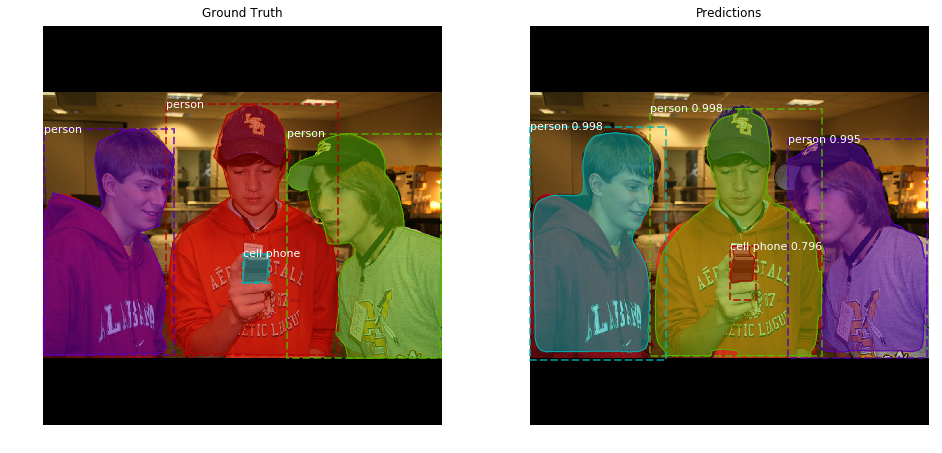

In [55]:
image_id = random.choice(dataset.image_ids)
# todo: option for load_image_gt() to skip resizing
image, image_meta, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID {}: ({}.{}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# todo: make class_ids a standard output
gt_class_id = gt_bbox[:, 4]

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1, 2)
r = results[0]
visualize.display_instances(image, gt_bbox[:,:4], gt_mask, gt_bbox[:,4], 
                            dataset.class_names, ax=ax[0], title="Ground Truth")
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax[1],
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Precision-Recall

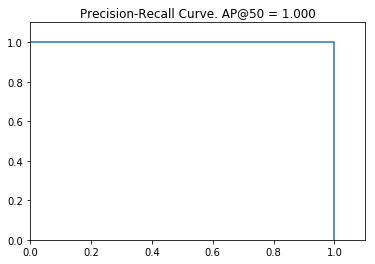

In [56]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = common.compute_ap(gt_bbox[:,:4], gt_bbox[:,4], 
                                          r['rois'], r['class_ids'], r['scores'])
visualize.plot_precision_recall(AP, precisions, recalls)

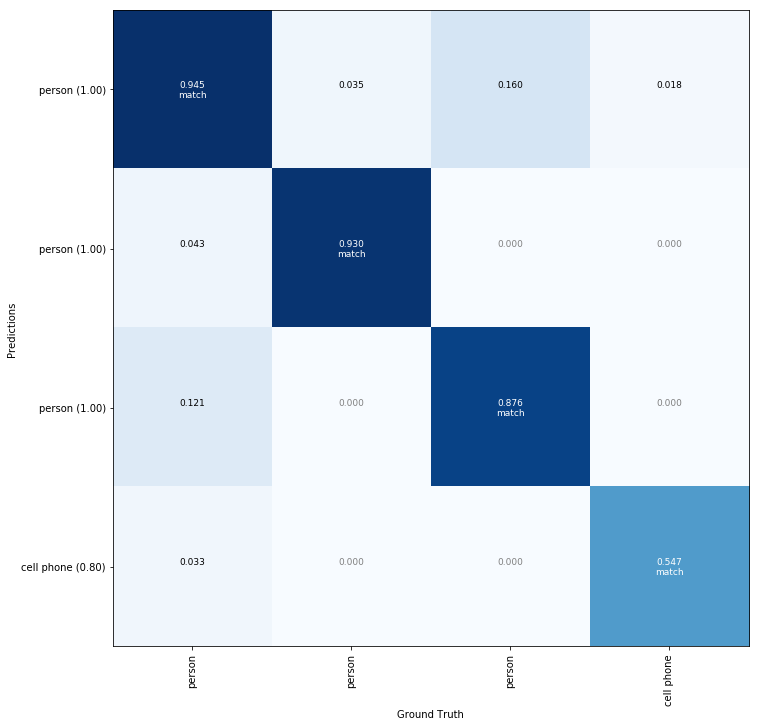

In [57]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_bbox[:, 4], r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [11]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            common.compute_ap(gt_bbox[:,:4], gt_bbox[:,4],
                              r['rois'], r['class_ids'], r['scores'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

/usr/local/lib/python3.5/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


mAP @ IoU=50:  0.621775034238


## Step by Step Prediction

In [12]:
# # Recreate the model in training mode.
# if TEST_MODE == "training":
#     # todo: support mini_masks
#     with tf.device(DEVICE):
#         model = modellib.build_mask_rcnn(mode="training", config=config)
#     model.load_weights(TEST_MODEL, by_name=True)

In [13]:
# # Run object detection
# if TEST_MODE == "training":
#     inputs = [normalized_images, image_meta, target_rpn_match, 
#               target_rpn_bbox, gt_boxes, gt_masks]
#     if not config.USE_RPN_ROIS:
#         inputs.append(target_rois)
    
#     rpn_class_logits, rpn_class, rpn_bbox,\
#     mrcnn_class_logits, mrcnn_class, mrcnn_bbox, mrcnn_mask,\
#     rpn_rois, rois,\
#     rpn_class_loss, rpn_bbox_loss, class_loss, bbox_loss, mask_loss = \
#         model.predict(inputs, verbose=1)
#     tensor_summary(target_rpn_match, "target_rpn_match")
# else:
#     detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, rois, \
#     rpn_class, rpn_bbox = model.predict([normalized_images, image_meta], verbose=1)
#     tensor_summary(detections, "detections")

# tensor_summary(rpn_class, "rpn_class")
# tensor_summary(rpn_bbox, "rpn_bbox")
# tensor_summary(mrcnn_class, "mrcnn_class")
# tensor_summary(mrcnn_bbox, "mrcnn_bbox")
# tensor_summary(mrcnn_mask, "mrcnn_mask")
# tensor_summary(rois, "rois")

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchros to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [58]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = common.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000
target_rpn_bbox          shape: (256, 4)              min:   -1.27194  max:    1.16237
positive_anchors         shape: (5, 4)                min:  -53.01934  max: 1024.00000
negative_anchors         shape: (251, 4)              min: -362.03867  max: 1152.00000
neutral anchors          shape: (65216, 4)            min: -362.03867  max: 1258.03867
refined_anchors          shape: (5, 4)                min:    1.00000  max: 1024.00000


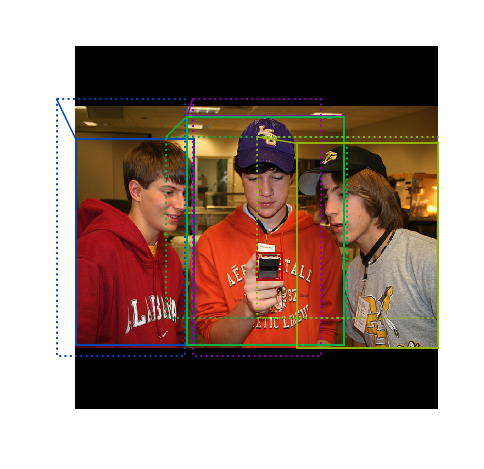

In [59]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [60]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from
rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000
pre_nms_anchors          shape: (1, 10000, 4)         min: -362.03867  max: 1258.03870
refined_anchors          shape: (1, 10000, 4)         min: -597.26001  max: 1674.88452
refined_anchors_clipped  shape: (1, 10000, 4)         min:    0.00000  max: 1024.00000
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1522.00000
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


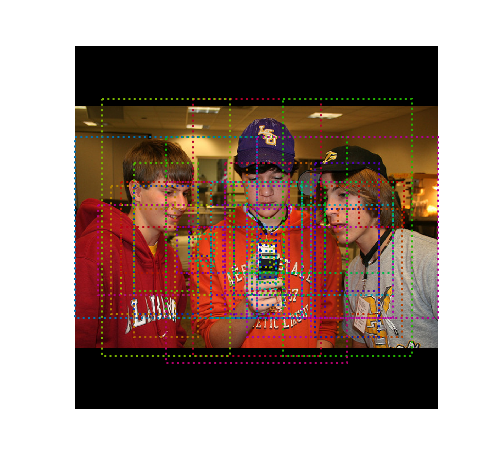

In [61]:
# Show top anchors by score (before refinement)
limit = 50
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

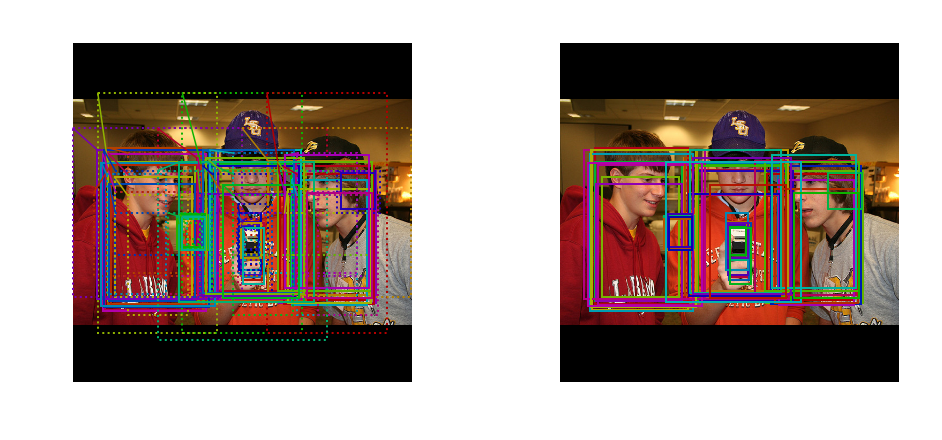

In [62]:
# Show top anchors with refinment. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
visualize.draw_boxes(image, boxes=rpn["pre_nms_anchors"][0, :limit], 
           refined_boxes=rpn["refined_anchors"][0, :limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, :limit], ax=ax[1])

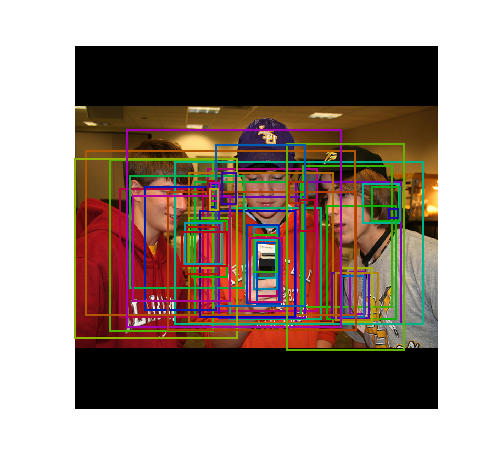

In [63]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

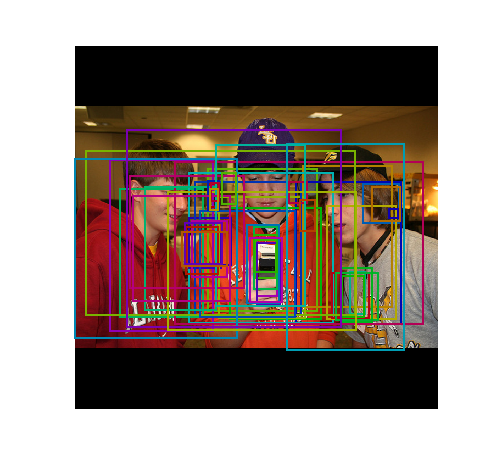

In [64]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [65]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = common.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = common.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = common.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))


All Anchors (65472)       Recall: 0.500  Positive anchors: 3
Refined Anchors (10000)   Recall: 0.750  Positive anchors: 18
Post NMS Anchors (   50)  Recall: 0.000  Positive anchors: 0


## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [86]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),  # todo: rename bbox to deltas
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000
probs                    shape: (1, 1000, 81)         min:    0.00000  max:    0.99999
deltas                   shape: (1, 1000, 81, 4)      min:   -4.13370  max:    3.06852
masks                    shape: (1, 100, 28, 28, 81)  min:    0.00000  max:    0.99993
detections               shape: (1, 100, 6)           min:    0.00000  max:  910.00000


4 detections: ['person' 'person' 'person' 'cell phone']


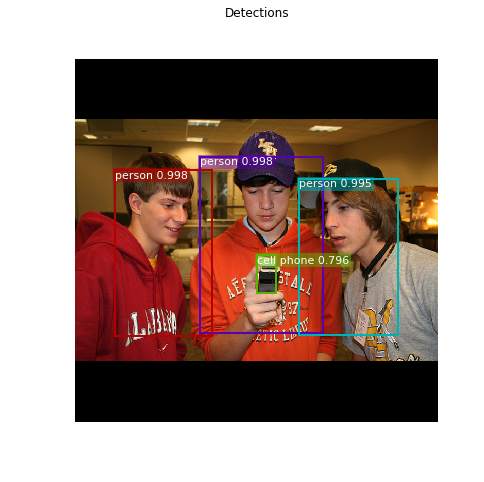

In [88]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [69]:
# # todo
# _, _, windows, _ = common.parse_image_meta(image_meta[np.newaxis,...])

In [89]:
# detections = modellib.refine_rois(mrcnn["proposals"][0], mrcnn["probs"][0], 
#                                   mrcnn["deltas"][0], windows[0], config)
# log("detections", detections)

# captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
#             for c, s in zip(detections[:, 4], detections[:, 5])]
# visualize.draw_boxes(
#     image, 
#     refined_boxes=detections[:, :4],
#     visibilities=[2] * len(detections),
#     captions=captions, title="Detections",
#     ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [92]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)
# Exclude boxes with zero area
# todo: roi_boxes = roi_boxes[((roi_boxes[:,2] - roi_boxes[:,0]) > 0) & ((roi_boxes[:,3] - roi_boxes[:,1]) > 0)]

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
40 Positive ROIs
[('BG', 960), ('cell phone', 2), ('person', 38)]


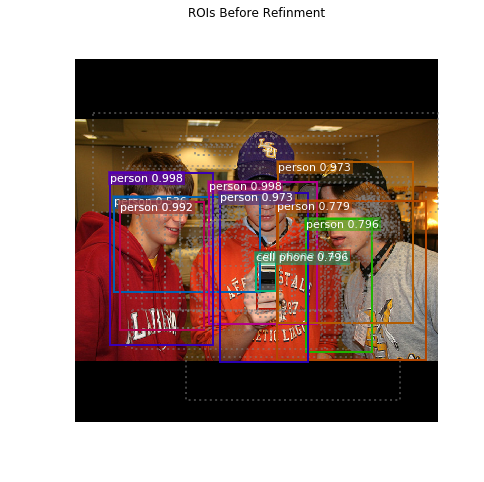

In [94]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 0),
                     captions=captions, title="ROIs Before Refinment",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -3.71422  max:    3.06852
refined_proposals        shape: (1000, 4)             min:    8.00000  max: 1063.00000


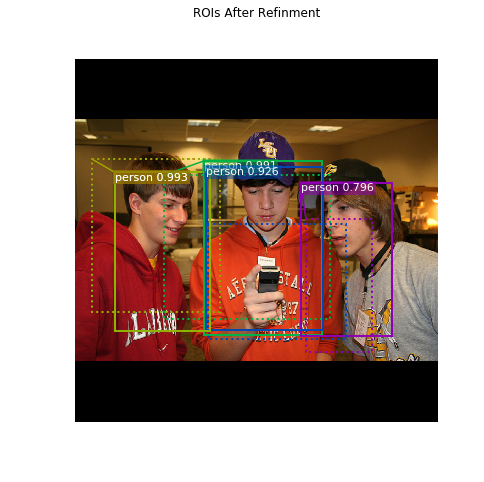

In [95]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = common.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
ids = np.random.randint(0, len(roi_positive_ixs), 5)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinment",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [96]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 40 detections:
[  0   1   2   3   4   5  10  11  13  19  24  30  31  34  36  38  58  59
  61  79  80  83  86  87  99 104 120 121 130 147 259 361 389 413 474 509
 516 551 879 978]


In [97]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.5 confidence. Keep 39:
[  1   2   3   4   5  10  11  13  19  24  30  31  34  36  38  58  59  61
  79  80  83  86  87  99 104 120 121 130 147 259 361 389 413 474 509 516
 551 879 978]


#### Per-Class Non-Max Suppression

In [98]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = common.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

person                : [  1   2   4   5  10  11  13  19  24  30  31  34  36  38  58  59  61  79
  80  83  86  87  99 104 120 121 130 147 259 361 389 413 474 509 516 551
 879 978] -> [1 2 4]
cell phone            : [3] -> [3]

Kept after per-class NMS: 4
[1 2 3 4]


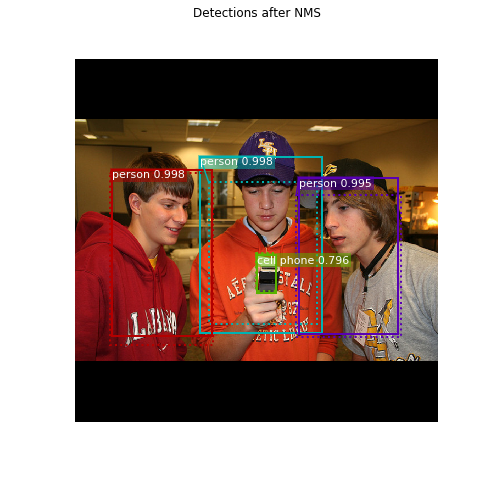

In [99]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

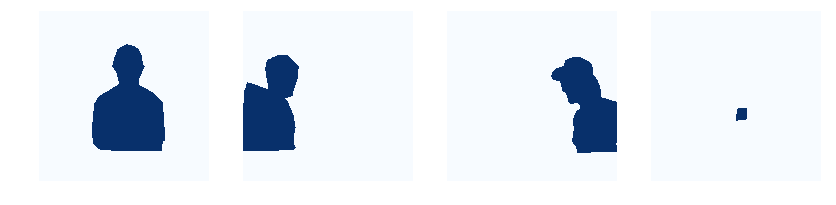

In [100]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [101]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:  910.00000
masks                    shape: (1, 100, 28, 28, 81)  min:    0.00000  max:    0.99993
4 detections: ['person' 'person' 'person' 'cell phone']


In [102]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([common.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (4, 28, 28)           min:    0.00002  max:    0.99993
det_masks                shape: (4, 1024, 1024)       min:    0.00000  max:    1.00000


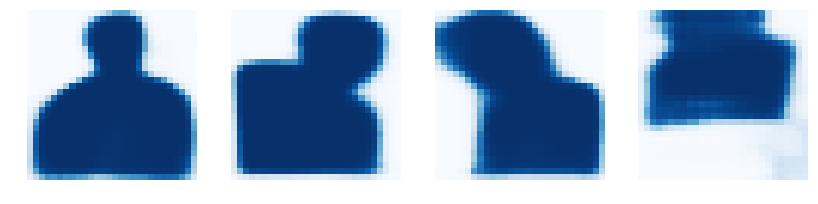

In [103]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

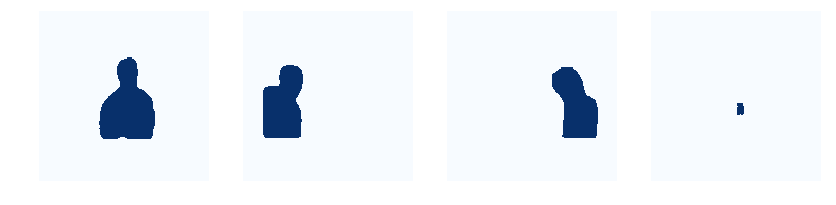

In [104]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [122]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.68000  max:  150.06100
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   56.43117
rpn_bbox                 shape: (1, 65472, 4)         min:  -11.96844  max:   18.29112
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000


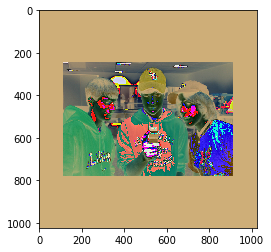

In [123]:
# Input image (normalized)
_ = plt.imshow(activations["input_image"][0])

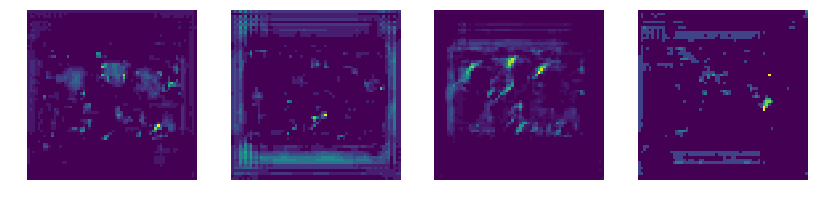

In [124]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

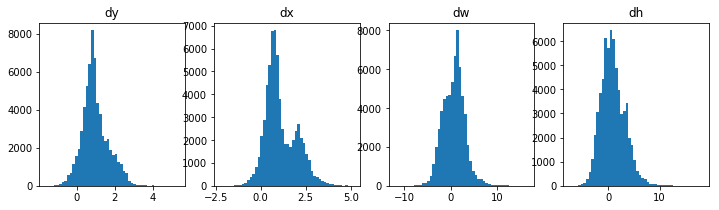

In [125]:
# Histograms of RPN bounding box deltas
plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.title("dy")
_ = plt.hist(activations["rpn_bbox"][0,:,0], 50)
plt.subplot(1, 4, 2)
plt.title("dx")
_ = plt.hist(activations["rpn_bbox"][0,:,1], 50)
plt.subplot(1, 4, 3)
plt.title("dw")
_ = plt.hist(activations["rpn_bbox"][0,:,2], 50)
plt.subplot(1, 4, 4)
plt.title("dh")
_ = plt.hist(activations["rpn_bbox"][0,:,3], 50)

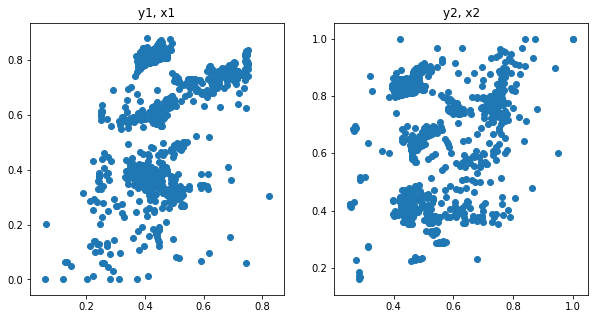

In [126]:
# Distribution of y, x coordinates of generated proposals
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("y1, x1")
plt.scatter(activations["roi"][0,:,0], activations["roi"][0,:,1])
plt.subplot(1, 2, 2)
plt.title("y2, x2")
plt.scatter(activations["roi"][0,:,2], activations["roi"][0,:,3])
plt.show()